Read the vision transformer paper here: https://arxiv.org/pdf/2010.11929.pdf

In [1]:
import torch 
import torchvision 
from torchvision import transforms

import matplotlib.pyplot as plt

from going_modular import engine, data_setup
from helper_functions import set_seeds, download_data, plot_loss_curves

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi"
)
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [4]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [5]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [6]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x254521e3f40>,
 ['pizza', 'steak', 'sushi'])

In [7]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

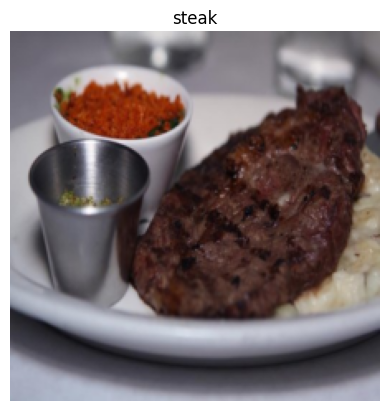

In [8]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

In [9]:
height = 224 # H
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

number_of_patches = int((height * width) / (patch_size ** 2))
print(f"Number of patches (N) with image height (H={height}), width (W={width}), and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224), and patch size (P=16): 196


In [10]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size ** 2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image): (196, 768)


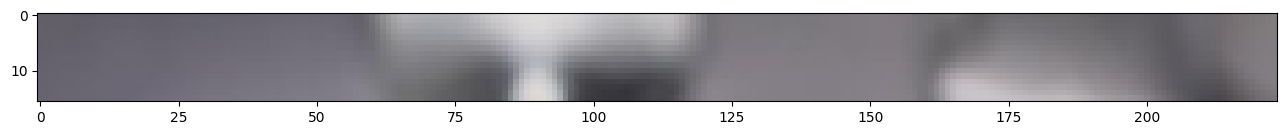

In [11]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

In [12]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image must be divisible by patch size"

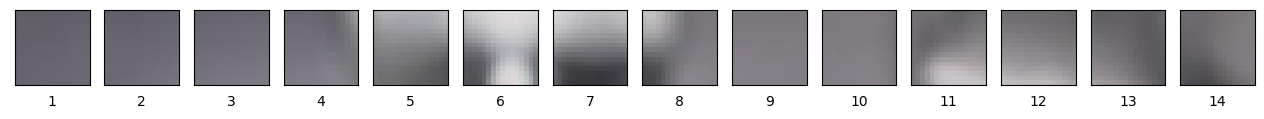

In [13]:
fig, axs = plt.subplots(
    nrows=1, 
    ncols=img_size // patch_size,
    sharex=True, 
    sharey=True,
    figsize=(patch_size, patch_size)
)

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


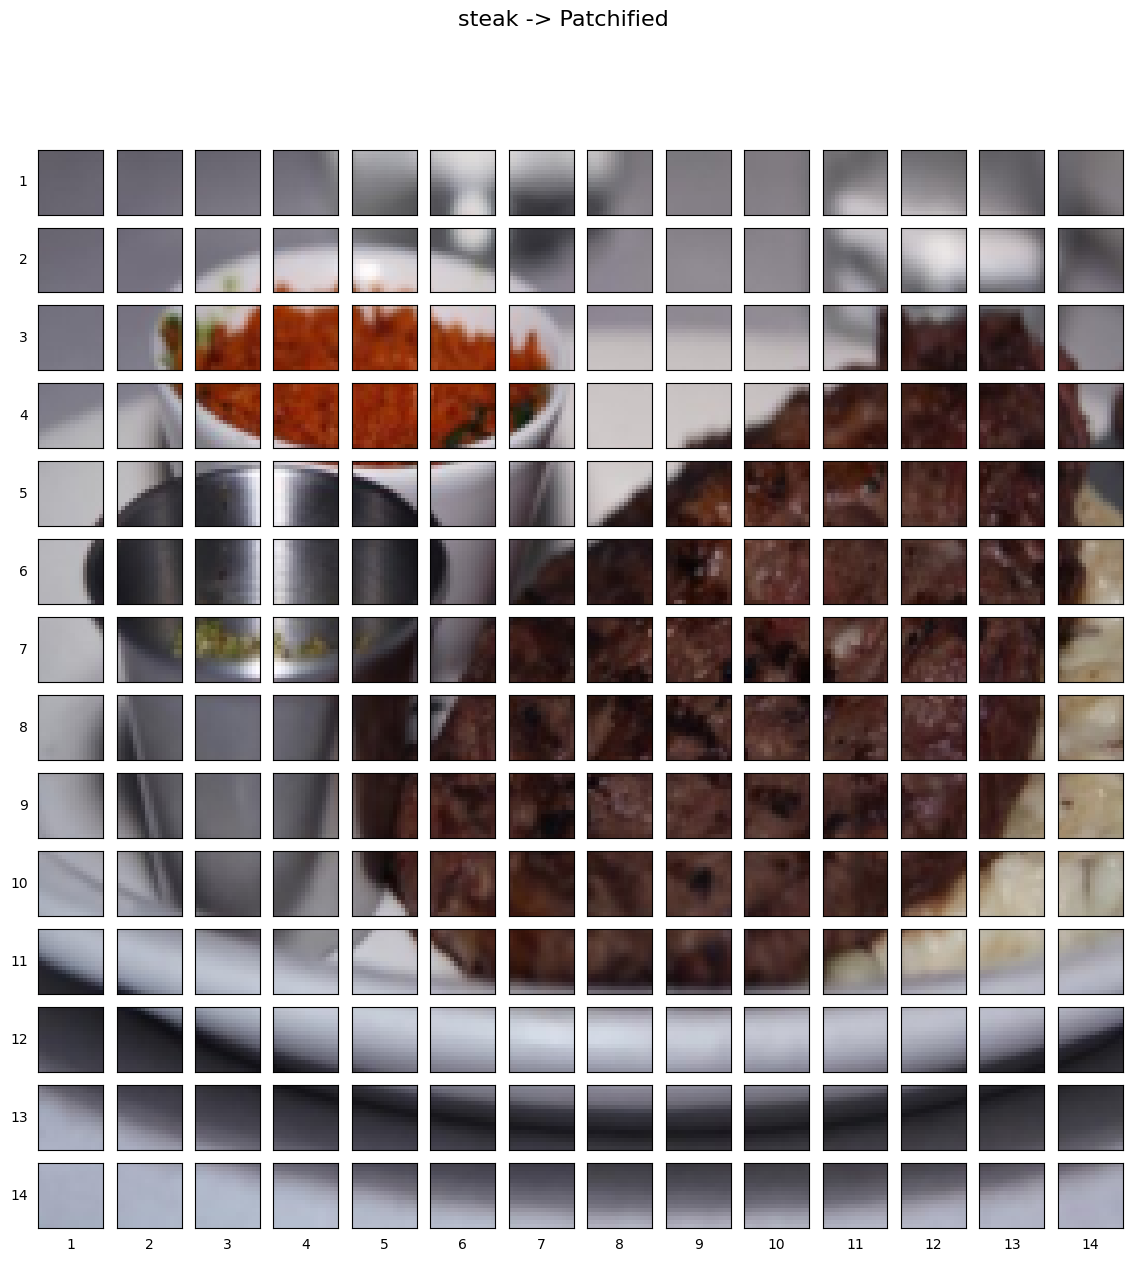

In [14]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [15]:
from torch import nn 

patch_size = 16 

# Create the Conv2d layer with hyperparamerters form the ViT paper
conv2d = nn.Conv2d(
    in_channels=3,
    out_channels=768,
    kernel_size=patch_size, 
    stride=patch_size,
    padding=8
)

In [16]:
# Pass one image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension to it
print(image_out_of_conv.shape)

torch.Size([1, 768, 15, 15])


torch.Size([1, 768, 15, 15]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]

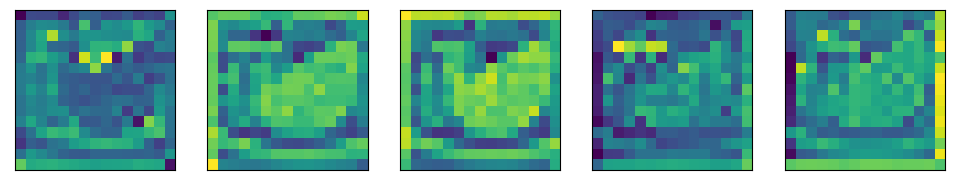

In [17]:
# Plot 5 random convolutional feature maps 
import random 
random_indexes = random.sample(range(0, 758), k=5)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # inex on the output tensr of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [18]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.0497, -0.0949, -0.0977, -0.1006, -0.1145, -0.1167, -0.1405,
           -0.0790, -0.1025, -0.1130, -0.1019, -0.1139, -0.1058, -0.0870,
           -0.0638],
          [ 0.0576,  0.1431,  0.1665,  0.1660,  0.1218,  0.0054,  0.2831,
            0.0677,  0.1876,  0.1802,  0.1656,  0.3215,  0.1826,  0.0720,
            0.0925],
          [ 0.0643,  0.1598,  0.2643,  0.2938,  0.3408,  0.2963,  0.2864,
            0.1590,  0.1769,  0.1801,  0.1568,  0.1732,  0.2754,  0.2040,
            0.0673],
          [ 0.0681,  0.1685,  0.1536,  0.0719,  0.1068,  0.1404,  0.1664,
            0.2244,  0.2874,  0.2708,  0.3991,  0.0586,  0.0223,  0.0368,
            0.0904],
          [ 0.0914,  0.2676,  0.2931,  0.3208,  0.1921,  0.0277,  0.2211,
            0.2825,  0.3331,  0.0634,  0.0480, -0.0109,  0.0227,  0.0270,
            0.0524],
          [ 0.1210,  0.2239,  0.0377,  0.2819,  0.0836,  0.0083,  0.1430,
            0.2878,  0.0547,  0.0570,  0.1215,  0.0724,  0.0659,  0.0454,
       

In [19]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 15, 15]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [20]:
# Create flatten layer
flatten = nn.Flatten(
    start_dim=2, # flatten feature_map_height (dimension 2)
    end_dim=3  # flatten feature_map_width (dimension 3)
) 

In [21]:
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Flattened image feature map shape: torch.Size([1, 768, 225])


In [22]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 225, 768]) -> [batch_size, num_patches, embedding_size]


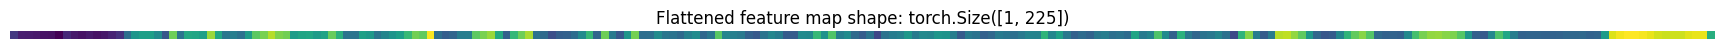

In [23]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [24]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-0.0497, -0.0949, -0.0977, -0.1006, -0.1145, -0.1167, -0.1405, -0.0790,
          -0.1025, -0.1130, -0.1019, -0.1139, -0.1058, -0.0870, -0.0638,  0.0576,
           0.1431,  0.1665,  0.1660,  0.1218,  0.0054,  0.2831,  0.0677,  0.1876,
           0.1802,  0.1656,  0.3215,  0.1826,  0.0720,  0.0925,  0.0643,  0.1598,
           0.2643,  0.2938,  0.3408,  0.2963,  0.2864,  0.1590,  0.1769,  0.1801,
           0.1568,  0.1732,  0.2754,  0.2040,  0.0673,  0.0681,  0.1685,  0.1536,
           0.0719,  0.1068,  0.1404,  0.1664,  0.2244,  0.2874,  0.2708,  0.3991,
           0.0586,  0.0223,  0.0368,  0.0904,  0.0914,  0.2676,  0.2931,  0.3208,
           0.1921,  0.0277,  0.2211,  0.2825,  0.3331,  0.0634,  0.0480, -0.0109,
           0.0227,  0.0270,  0.0524,  0.1210,  0.2239,  0.0377,  0.2819,  0.0836,
           0.0083,  0.1430,  0.2878,  0.0547,  0.0570,  0.1215,  0.0724,  0.0659,
           0.0454,  0.0959,  0.1214,  0.0412,  0.0755,  0.2626,  0.1039,  0.0937,
           0.079

In [25]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """

    def __init__(
            self,
            in_channels: int=3,
            patch_size: int=16,
            embedding_dim: int=768
    ):
        super().__init__()
        
        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0
        )

        self.flatten = nn.Flatten(
            start_dim=2,
            end_dim=3
        )

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisibe by patch_size, image shape: {image_resolution}, patch_size: {patch_size}"

        # Perform the forward pass 
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1)

In [26]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(
    in_channels=3,
    patch_size=16,
    embedding_dim=768
)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [27]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.4311,  0.1090, -0.1443,  ...,  0.3269, -0.1779,  0.1475],
         [-0.4563,  0.1131, -0.1549,  ...,  0.3406, -0.1842,  0.1524],
         [-0.4814,  0.1242, -0.1687,  ...,  0.3643, -0.1893,  0.1667],
         ...,
         [-0.5227,  0.1364, -0.3613,  ...,  0.4527, -0.0904,  0.2373],
         [-0.6345,  0.1791, -0.3378,  ...,  0.4675, -0.1186,  0.2569],
         [-0.7544,  0.2270, -0.2469,  ...,  0.4942, -0.2256,  0.2238]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [31]:
class MultiHeadSelfAttentionBlock(nn.Module):
    def __init__(self, 
                 embedding_dim: int=768,
                 num_heads: int=12,
                 attention_dropout: int=0):

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            batch_first=True
        )

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(
            query=x, 
            key=x,
            value=x,
            weights=False
        )
        return attn_output